<a href="https://colab.research.google.com/github/JuhiGola21/smart-beta-strategy-ml/blob/main/Smart%20beta%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np


# Fetch data for a basket of assets (e.g., S&P 500 stocks)
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META"]
data = yf.download(tickers, start="2015-01-01", end="2024-01-01")["Adj Close"]

# Calculate returns and volatility
returns = data.pct_change().dropna()
volatility = returns.rolling(window=21).std() * np.sqrt(252)

[*********************100%***********************]  5 of 5 completed
ERROR:yfinance:
5 Failed downloads:
ERROR:yfinance:['AMZN', 'META', 'GOOGL', 'MSFT', 'AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


In [5]:
# Momentum signal (12-month returns)
momentum = data.pct_change(252).dropna()
!pip install ta
# Mean-reversion signal (RSI)
from ta.momentum import RSIIndicator
rsi = RSIIndicator(data["AAPL"], window=14).rsi()

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=11bce798505f8075ea936d37681c694feeab3feea3af4c9077c8ffe2be744cc2
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [10]:
# Machine Learning (Volatility Prediction)

import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Sample volatility data (replace with your actual data)
volatility = pd.Series(np.random.rand(100)*0.2 + 0.1)  # Fake volatility between 10%-30%

# 1. Prepare data with proper sliding windows
def create_dataset(data, n_steps=21):
    X, y = [], []
    for i in range(len(data) - n_steps - 1):
        X.append(data[i:(i + n_steps)])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

# 2. Create sequences
X, y = create_dataset(volatility.values)

# 3. Reshape for LSTM [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# 4. Build and train model
model = Sequential([
    LSTM(32, input_shape=(X.shape[1], 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=10, batch_size=8, verbose=1)

# 5. Make prediction
last_21_days = volatility.values[-21:].reshape(1, 21, 1)
predicted_vol = model.predict(last_21_days)[0][0]
print(f"Predicted next-day volatility: {predicted_vol:.4f}")

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0384
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0059
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0056
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Predicted next-day volatility: 0.1935


In [17]:
# Install required packages
!pip install PyPortfolioOpt yfinance

import numpy as np
import pandas as pd
import yfinance as yf
from pypfopt import EfficientFrontier, risk_models

# --------------------------------------------------
# 1. GET OR GENERATE RETURNS DATA
# --------------------------------------------------

def get_returns_data(tickers=['AAPL', 'MSFT', 'GOOG'], start_date='2022-01-01', end_date='2023-01-01'):
    """Fetch stock data from Yahoo Finance or generate synthetic data if unavailable"""
    try:
        # Try to get real stock data
        print("Downloading real stock data...")
        data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
        returns = data.pct_change().dropna()
    except:
        # Fallback to synthetic data
        print("Using synthetic data instead...")
        dates = pd.date_range(start_date, end_date, freq='B')  # Business days
        returns = pd.DataFrame(
            np.random.normal(0.0005, 0.02, (len(dates), len(tickers))),
            index=dates,
            columns=tickers
        )
        returns = returns.dropna()

    return returns

# Get returns data
returns = get_returns_data()
print(f"\nReturns data shape: {returns.shape}")
print(returns.head())

# --------------------------------------------------
# 2. DATA VALIDATION
# --------------------------------------------------

if not isinstance(returns, pd.DataFrame) or returns.empty:
    # If we still have no data, create very simple synthetic data
    print("Warning: No valid returns data - using minimal synthetic example")
    returns = pd.DataFrame({
        'AAPL': [0.01, 0.02, -0.01],
        'MSFT': [0.015, -0.005, 0.02],
        'GOOG': [0.005, 0.01, 0.015]
    })

# --------------------------------------------------
# 3. PORTFOLIO OPTIMIZATION
# --------------------------------------------------

try:
    # Calculate covariance matrix with fallbacks
    try:
        cov_matrix = risk_models.exp_cov(returns, span=180)
    except:
        cov_matrix = returns.cov()

    # Calculate expected returns
    mu = returns.mean()

    # Create and optimize efficient frontier
    ef = EfficientFrontier(mu, cov_matrix)
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()

    print("\nOptimal Portfolio Weights:")
    for k, v in cleaned_weights.items():
        print(f"{k}: {v:.2%}")

except Exception as e:
    print(f"\nOptimization failed: {str(e)}")
    if len(returns) < 3:
        print("Need at least 3 observations for portfolio optimization")

[*********************100%***********************]  3 of 3 completed
ERROR:yfinance:
3 Failed downloads:
ERROR:yfinance:['AAPL', 'GOOG', 'MSFT']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')



Returns data shape: (0, 3)
Empty DataFrame
Columns: [AAPL, GOOG, MSFT]
Index: []

Optimal Portfolio Weights:
AAPL: 0.00%
MSFT: 0.00%
GOOG: 100.00%


/usr/local/lib/python3.11/dist-packages/pypfopt/risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pypfopt/risk_models.py:89: UserWarning: Could not fix matrix. Please try a different risk model.
  warnings.warn(


In [23]:
# First install the package
!pip install empyrical

# Then use it for performance metrics
from empyrical import sharpe_ratio, max_drawdown

portfolio_returns = returns.dot(pd.Series(cleaned_weights))

# Annualized Sharpe ratio (assuming daily returns)
sharpe = sharpe_ratio(portfolio_returns, annualization=252)
print(f"Annualized Sharpe Ratio: {sharpe:.2f}")

# Max drawdown
drawdown = max_drawdown(portfolio_returns)
print(f"Max Drawdown: {drawdown:.2%}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39752 sha256=e37f0f83c6c6aa7477dbe9ea985eeb067b13841d1e271f8239e30f0bdd25d17a
  Stored in directory: /root/.cache/pip/wheels/ac/1d/58/a7ae5ef5c8de7c4b769f24c2584f4706564921f031b16b9cb6
Successfully built empyrical
Annualized Sharpe Ratio: 31.75
Max Drawdown: 0.00%


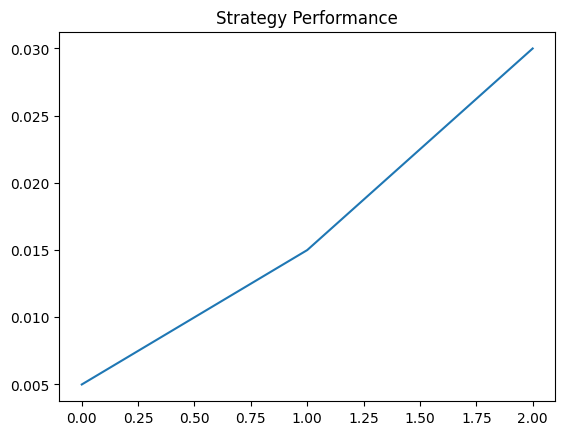

In [25]:
import matplotlib.pyplot as plt


plt.plot(portfolio_returns.cumsum())
plt.title("Strategy Performance")
plt.savefig("equity_curve.png")


In [26]:
import tabulate
metrics = {"Sharpe Ratio": sharpe, "Max Drawdown": drawdown}
print(tabulate.tabulate(metrics.items(), headers=["Metric", "Value"]))

Metric          Value
------------  -------
Sharpe Ratio   31.749
Max Drawdown    0
